## Analysis for Cortical Cell Images

A comprehensive workflow for enhancing microscopy images of cortical cells and performing FFT analysis on them.

Developed by: 
Roberto dos Reis, PhD - Northwestern Univeristy/2025 

roberto.reis@northwestern.edu

and

Paloma Lee - Northwestern University/2025

palomalee2025@u.northwestern.edu


This notebook is part of the paper entitled:
(TBD)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure
from pathlib import Path

import ncempy.io as nio

from scipy.ndimage import median_filter
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.patches import Rectangle
from matplotlib_scalebar.scalebar import ScaleBar


## Load and Display the Original Image

First, let's load the image and examine it.

In [8]:
# file_path = 'selected_images/2024-07-11_3200_Wool_Devon/Devon_5E w UA -EtOH_20kX_0031.dm4' #linear
# file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0032.dm4' #linear
 
# file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0013.dm4' #circular
# file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0021.dm4' #circular
# file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0022.dm4' #circular

# file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0034.dm4' #hex
file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0035.dm4' #hex


In [22]:
def load_dm4(file_path):
    dmData = nio.read(file_path)
    return dmData

im_data= load_dm4(file_path)

print(im_data['data'].shape) # the shape of the data
print(im_data['pixelSize']) # print the pixel size

img = im_data['data']
scale = im_data['pixelSize']

(3838, 3710)
[0.18341091, 0.18341091]


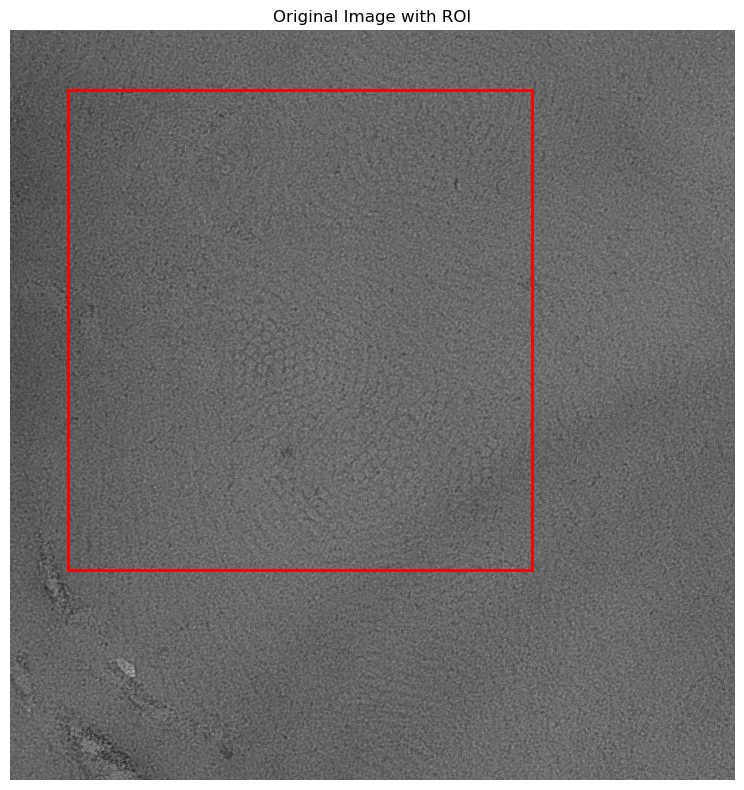

In [24]:
# Crop the image to focus on the region of interest
# Adjust these values based on your specific image
height, width = img.shape
crop_top = int(height * 0.1)  # Crop 10% from top
crop_bottom = int(height * 0.9)  # Keep up to 90% of height
crop_left = int(width * 0.1)  # Crop 10% from left
crop_right = int(width * 0.9)  # Keep up to 90% of width

img_crop = img[crop_top:crop_bottom, crop_left:crop_right]
# Display the cropped region overlaid on the original image
plt.figure(figsize=(10, 8))
plt.imshow(im_data['data'], cmap='gray')
plt.title('Original Image with ROI')

# Create a rectangle patch for the ROI
roi_rect = Rectangle((crop_left, crop_top), 
                     crop_right - crop_left, 
                     crop_bottom - crop_top,
                     linewidth=2, 
                     edgecolor='r', 
                     facecolor='none')

# Add the rectangle to the plot
plt.gca().add_patch(roi_rect)

plt.axis('off')
plt.tight_layout()
plt.show()


In [79]:
# # Replace with the path to your image for a png/tiff image
# image_path = 'images/B_nonmag.png'

# # Load the image
# try:
#     img = load_image(image_path)
#     display_image(img, 'Original Image')
# except FileNotFoundError:
#     print("Please update the image_path variable with the correct path to your image.")
#     # You can also use a sample image for testing
#     # from skimage import data
#     # img = data.camera()
#     # display_image(img, 'Sample Test Image')

## Step 1: Image Pre-processing

Let's apply several pre-processing steps to enhance the image quality before FFT analysis.

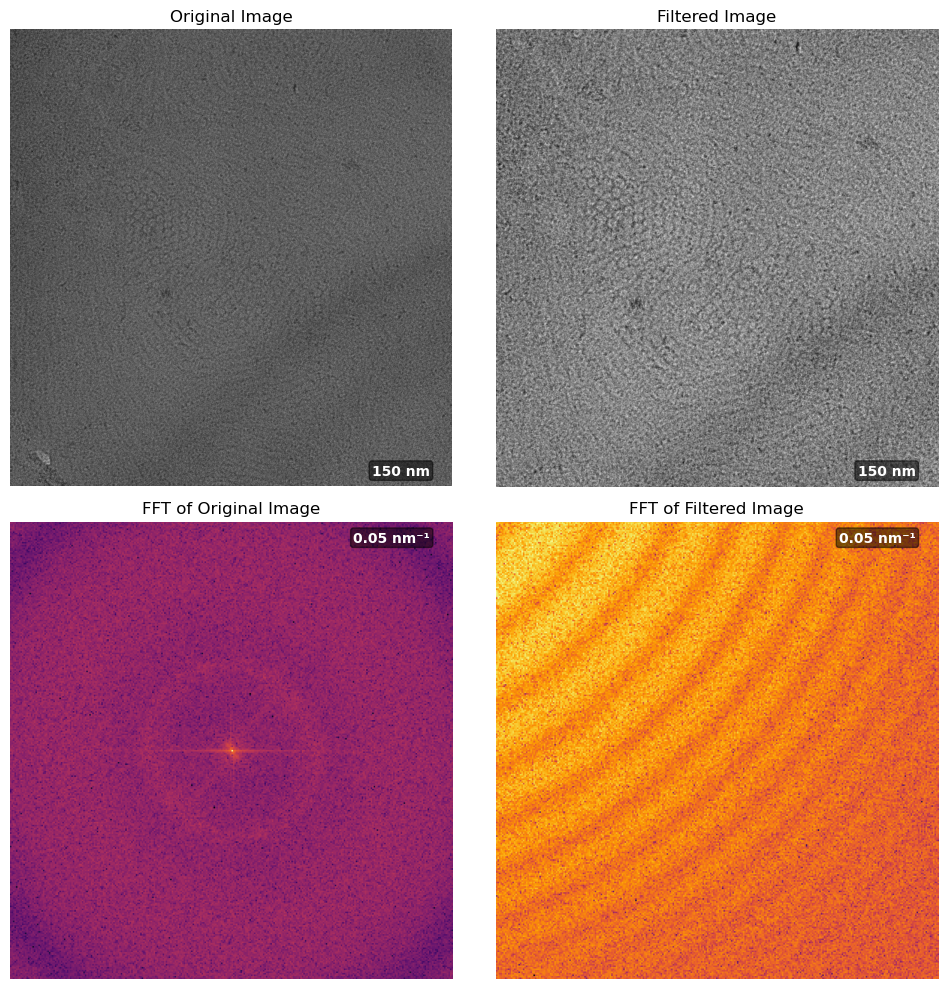

In [25]:
# Apply median filter
img_median = median_filter(img_crop, size=5)

# Calculate FFT
fft_original = np.fft.fftshift(np.fft.fft2(img))
fft_filtered = np.fft.fftshift(np.fft.fft2(img_median))

# Calculate magnitude and apply log scaling
mag_orig = np.log1p(np.abs(fft_original))
mag_filt = np.log1p(np.abs(fft_filtered))

# Crop FFT to central portion (5%)
crop_factor = 0.05
h, w = mag_orig.shape
crop_h, crop_w = int(h * crop_factor), int(w * crop_factor)
center_h, center_w = h // 2, w // 2

mag_orig_crop = mag_orig[center_h - crop_h:center_h + crop_h, 
                         center_w - crop_w:center_w + crop_w]
mag_filt_crop = mag_filt[center_h - crop_h:center_h + crop_h, 
                         center_w - crop_w:center_w + crop_w]

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Display original image
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# Display filtered image
axs[0, 1].imshow(img_median, cmap='gray')
axs[0, 1].set_title('Filtered Image')
axs[0, 1].axis('off')

# Display cropped FFT of original image
axs[1, 0].imshow(mag_orig_crop, cmap='inferno')
axs[1, 0].set_title('FFT of Original Image')
axs[1, 0].axis('off')

# Display cropped FFT of filtered image
axs[1, 1].imshow(mag_filt_crop, cmap='inferno')
axs[1, 1].set_title('FFT of Filtered Image')
axs[1, 1].axis('off')

# Add scale indicators to real-space images (top right corner)
bar_length_nm = 150  # scale in nm
for ax in [axs[0, 0], axs[0, 1]]:
    # Add text only in top-right corner
    ax.text(0.95, 0.05, f"{bar_length_nm} nm", 
            transform=ax.transAxes,  # Use axis coordinates (0-1)
            color='white', 
            fontsize=10,
            fontweight='bold',
            ha='right',  # Horizontal alignment
            va='top',    # Vertical alignment
            bbox=dict(facecolor='black', alpha=0.5, pad=2, boxstyle='round,pad=0.2'))

# Add scale indicators to FFT images
fft_scale_value = "0.05 nm⁻¹"
for ax in [axs[1, 0], axs[1, 1]]:
    # Add text only in bottom-right corner
    ax.text(0.95, 0.95, fft_scale_value, 
            transform=ax.transAxes,  # Use axis coordinates (0-1)
            color='white', 
            fontsize=10,
            fontweight='bold',
            ha='right',  # Horizontal alignment
            va='bottom', # Vertical alignment
            bbox=dict(facecolor='black', alpha=0.5, pad=2, boxstyle='round,pad=0.2'))

plt.tight_layout()
plt.savefig('em_image_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler
import cv2

def windowed_fft_decomposition(image, window_size=64, step=32, n_components=4, method='pca'):
    """
    Analyze image using windowed FFT and decompose patterns using PCA or NMF
    
    Parameters:
    -----------
    image : ndarray
        Input grayscale image
    window_size : int
        Size of the FFT window
    step : int
        Step size between windows
    n_components : int
        Number of components to extract
    method : str
        Decomposition method ('pca' or 'nmf')
        
    Returns:
    --------
    Dictionary containing decomposition results
    """
    h, w = image.shape
    
    # Create window function (Hann window)
    window = np.outer(np.hanning(window_size), np.hanning(window_size))
    
    # Calculate how many windows we'll have
    n_windows_y = (h - window_size) // step + 1
    n_windows_x = (w - window_size) // step + 1
    n_windows = n_windows_y * n_windows_x
    
    # Initialize feature matrix - each row is the FFT magnitude of one window
    # We'll use the lower half of the FFT (due to symmetry) as features
    fft_features = np.zeros((n_windows, (window_size//2+1) * window_size))
    
    # Track window positions
    window_positions = []
    
    # Extract FFT features from each window
    window_idx = 0
    for y in range(0, h-window_size+1, step):
        for x in range(0, w-window_size+1, step):
            # Extract window
            patch = image[y:y+window_size, x:x+window_size].copy()
            
            # Apply window function
            patch = patch * window
            
            # Compute FFT
            fft = np.fft.rfft2(patch)  # Use real FFT (faster, contains same info)
            magnitude = np.abs(fft)
            
            # Flatten and store as feature vector
            fft_features[window_idx] = magnitude.flatten()
            
            # Store window position
            window_positions.append((y, x))
            
            window_idx += 1
    
    # Normalize features
    if method == 'pca':
        # Standardize for PCA (zero mean, unit variance)
        scaler = StandardScaler()
        fft_features_scaled = scaler.fit_transform(fft_features)
        
        # Apply PCA
        decomposer = PCA(n_components=n_components)
        components = decomposer.fit_transform(fft_features_scaled)
        components_basis = decomposer.components_
        explained_var = decomposer.explained_variance_ratio_
        
    elif method == 'nmf':
        # Apply Non-negative Matrix Factorization
        # NMF works better with non-negative data (which FFT magnitudes are)
        decomposer = NMF(n_components=n_components, init='random', random_state=0)
        components = decomposer.fit_transform(fft_features)
        components_basis = decomposer.components_
        
        # For NMF, we calculate explained variance manually
        reconstruction = np.dot(components, components_basis)
        total_var = np.sum((fft_features - np.mean(fft_features, axis=0))**2)
        explained_var = 1 - np.sum((fft_features - reconstruction)**2) / total_var
        explained_var = [explained_var]  # Make it a list for consistent interface
    
    else:
        raise ValueError(f"Unknown decomposition method: {method}")
    
    # Reshape component weights into spatial maps
    component_maps = []
    for c in range(n_components):
        component_map = np.zeros((n_windows_y, n_windows_x))
        
        idx = 0
        for i in range(n_windows_y):
            for j in range(n_windows_x):
                component_map[i, j] = components[idx, c]
                idx += 1
        
        # Resize to original image dimensions for visualization
        resized_map = cv2.resize(component_map, (w, h), interpolation=cv2.INTER_LANCZOS4)
        component_maps.append(resized_map)
    
    # Reshape component basis functions back to FFT patterns
    component_patterns = []
    for c in range(n_components):
        basis = components_basis[c].reshape((window_size//2+1, window_size))
        component_patterns.append(basis)
    
    return {
        'component_maps': component_maps,
        'component_patterns': component_patterns,
        'explained_variance': explained_var,
        'window_size': window_size,
        'step': step,
        'method': method
    }

def visualize_fft_decomposition(image, decomposition_results):
    """
    Visualize the results of FFT decomposition
    
    Parameters:
    -----------
    image : ndarray
        Original image
    decomposition_results : dict
        Results from windowed_fft_decomposition
        
    Returns:
    --------
    Figure object
    """
    component_maps = decomposition_results['component_maps']
    component_patterns = decomposition_results['component_patterns']
    explained_var = decomposition_results['explained_variance']
    method = decomposition_results['method']
    n_components = len(component_maps)
    
    # Create figure
    fig, axes = plt.subplots(n_components, 3, figsize=(15, 4*n_components))
    
    if n_components == 1:
        axes = axes.reshape(1, -1)
    
    # First, show original image
    fig.suptitle(f"Windowed FFT {method.upper()} Decomposition", fontsize=16)
    
    # For each component
    for i in range(n_components):
        # Component spatial map
        im0 = axes[i, 0].imshow(component_maps[i], cmap='viridis')
        plt.colorbar(im0, ax=axes[i, 0])
        
        # Title with variance explained
        if method == 'pca' and i < len(explained_var):
            var_txt = f" ({explained_var[i]*100:.1f}% var)"
        elif method == 'nmf' and i == 0:
            var_txt = f" (Total explained: {explained_var[0]*100:.1f}%)"
        else:
            var_txt = ""
            
        axes[i, 0].set_title(f"Component {i+1} Map{var_txt}")
        axes[i, 0].axis('off')
        
        # Log FFT pattern for this component
        im1 = axes[i, 1].imshow(np.log1p(component_patterns[i]), cmap='inferno')
        plt.colorbar(im1, ax=axes[i, 1])
        axes[i, 1].set_title(f"Component {i+1} FFT Pattern")
        axes[i, 1].axis('off')
        
        # Overlay component map on original image
        overlay = np.zeros_like(image)
        overlay = cv2.normalize(component_maps[i], overlay, 0, 1, cv2.NORM_MINMAX)
        
        # Create false color overlay
        overlay_rgb = np.zeros((*image.shape, 3))
        overlay_rgb[..., 0] = image / np.max(image)  # Red channel = original image
        overlay_rgb[..., 1] = overlay  # Green channel = component strength
        overlay_rgb[..., 2] = 0  # Blue channel = 0
        
        # Adjust contrast for better visibility
        overlay_rgb = np.clip(overlay_rgb * 1.5, 0, 1)
        
        im2 = axes[i, 2].imshow(overlay_rgb)
        axes[i, 2].set_title(f"Component {i+1} Overlay")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    return fig

# Function to combine both methods for comparison
def analyze_em_image_patterns(image, window_sizes=[64, 128], n_components=4):
    """
    Analyze EM image patterns using both PCA and NMF on windowed FFT data
    
    Parameters:
    -----------
    image : ndarray
        Input grayscale image
    window_sizes : list
        List of window sizes to try
    n_components : int
        Number of components to extract
        
    Returns:
    --------
    Dictionary of results
    """
    results = {}
    
    for window_size in window_sizes:
        # PCA decomposition
        pca_results = windowed_fft_decomposition(
            image, window_size=window_size, step=window_size//2, 
            n_components=n_components, method='pca'
        )
        
        # NMF decomposition
        nmf_results = windowed_fft_decomposition(
            image, window_size=window_size, step=window_size//2, 
            n_components=n_components, method='nmf'
        )
        
        results[f'pca_win{window_size}'] = pca_results
        results[f'nmf_win{window_size}'] = nmf_results
    
    return results



/Users/robertoreis/anaconda3/envs/advem/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/robertoreis/anaconda3/envs/advem/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


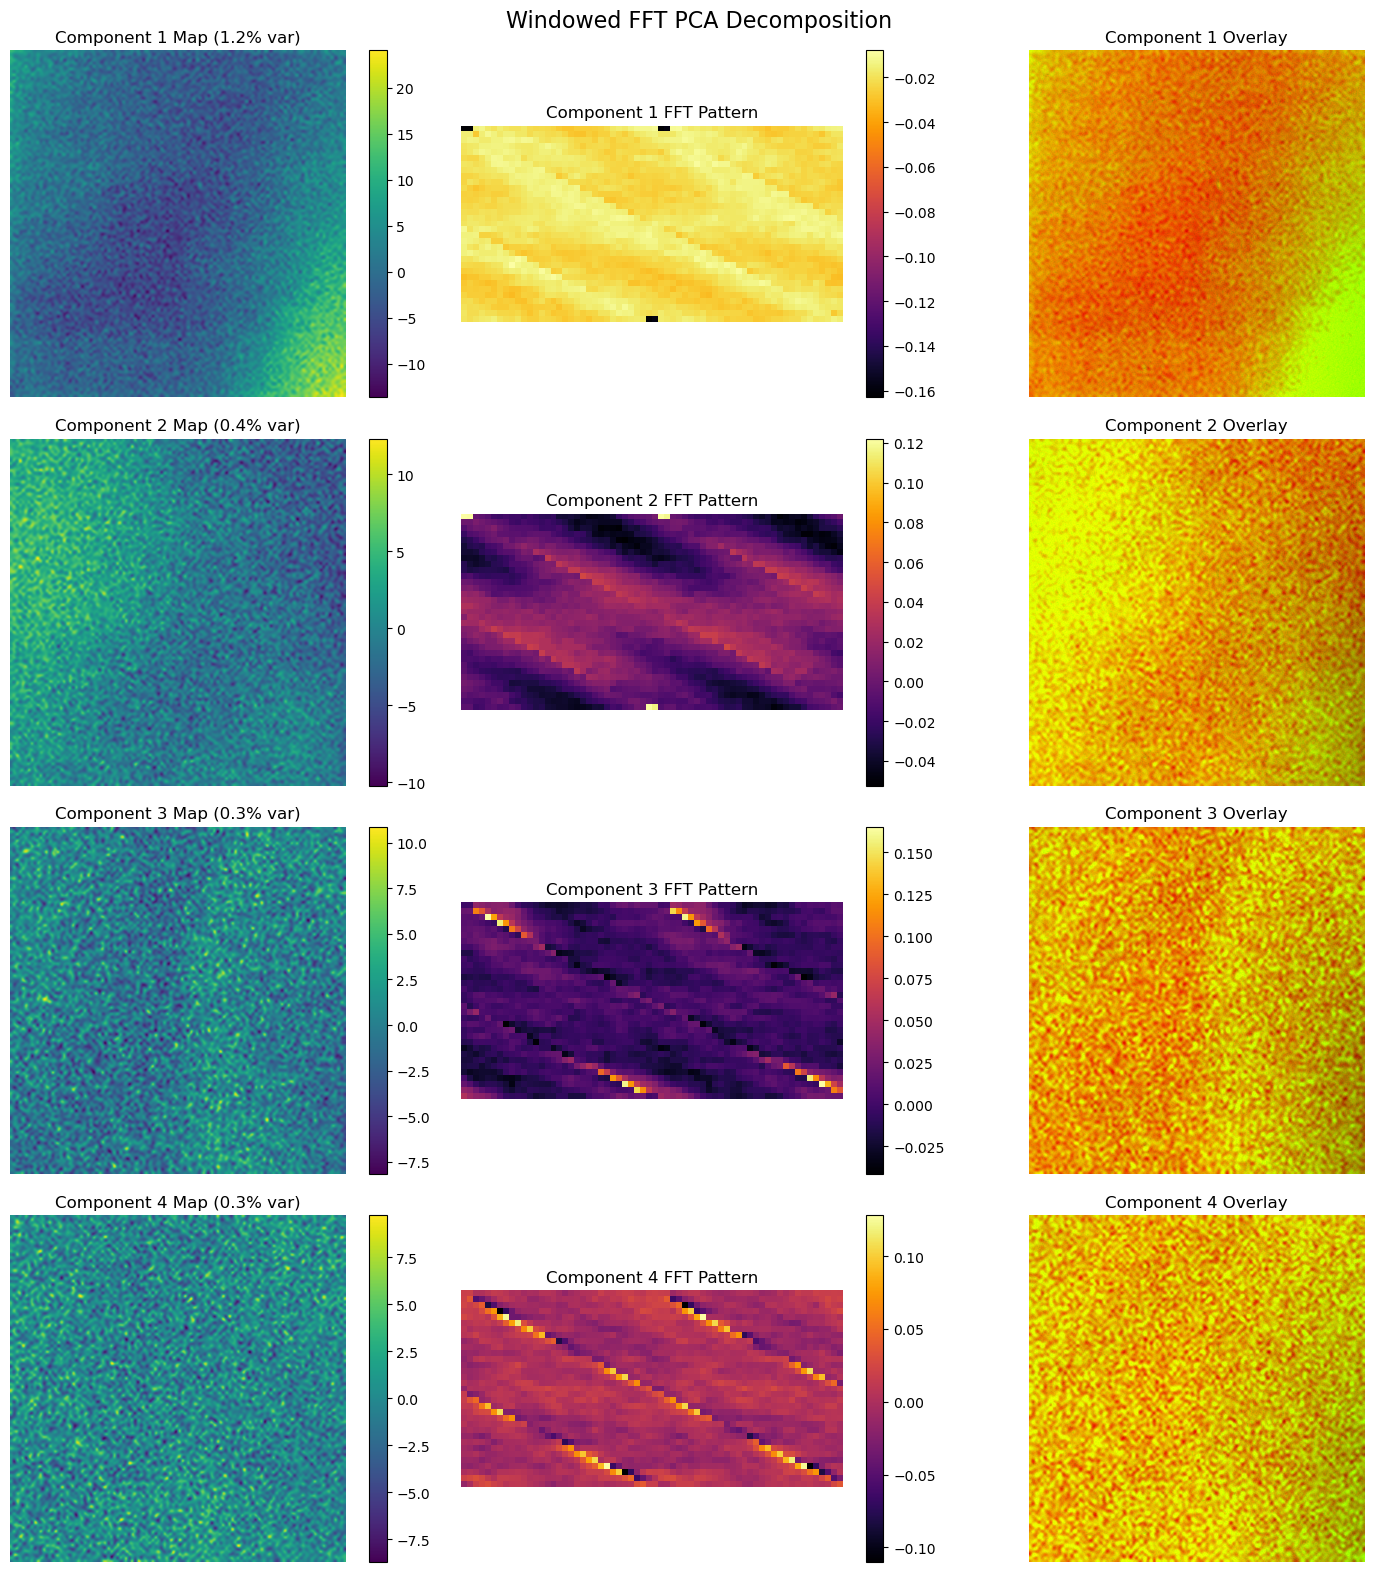

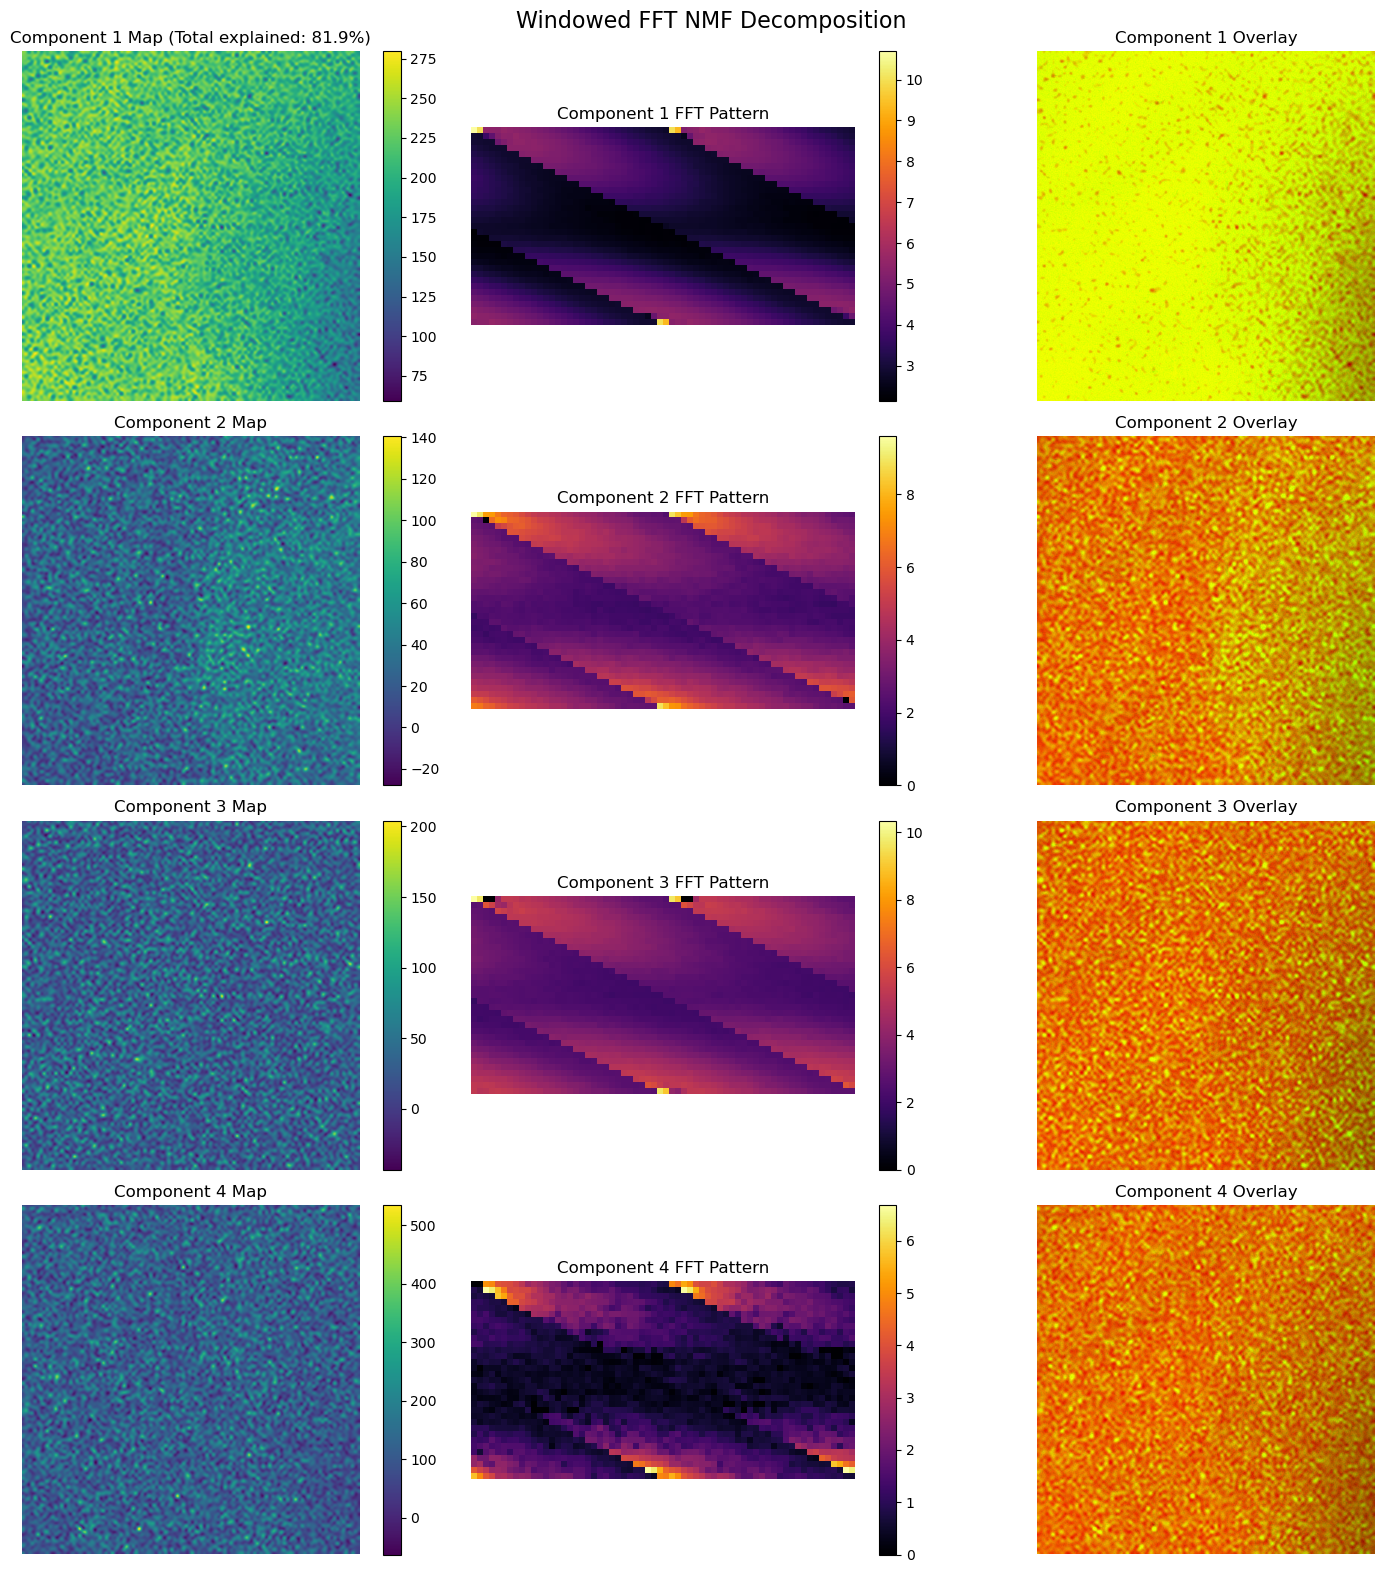

In [76]:
#  Example usage:
all_results = analyze_em_image_patterns(img, window_sizes=[64, 128], n_components=4)

# Visualize PCA results with 64px window
fig_pca_64 = visualize_fft_decomposition(img, all_results['pca_win64'])

# Visualize NMF results with 64px window
fig_nmf_64 = visualize_fft_decomposition(img, all_results['nmf_win64'])

plt.show()